# Time series correlations
Following this guide: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

In [22]:
import seaborn as sns

stock = "AAPL"

df = sentiment[stock].copy()

indices = [1,5,10]

for i in indices:
    df[f"return{i}"] = df.Close.pct_change(i)


df.set_index("date", inplace = True)

df["growth"] = df.pct_change(1).Close > 0

df.columns

# Pearson correlation — simple is best

Pandas computed Pearson r: 0.6071454876864526
Scipy computed Pearson r: 0.014587988356053442 and p-value: 0.6937570666251828


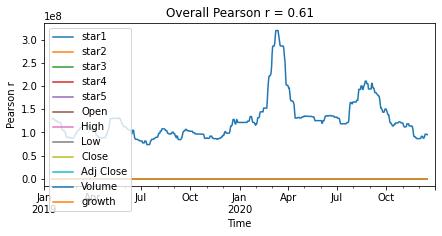

In [45]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(df.dropna()['star1'], df.dropna()['growth'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

# Time Lagged Cross Correlation — assessing signal dynamics


In [33]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

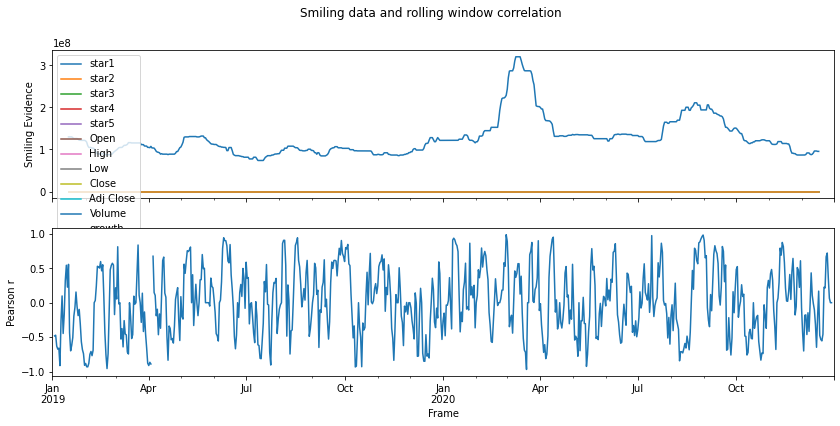

In [42]:
# Set window size to compute moving window synchrony.
r_window_size = 5
# Interpolate missing data.
df_interpolated = df.interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['star5'].rolling(window=r_window_size, center=True).corr(df_interpolated['growth'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df.rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")

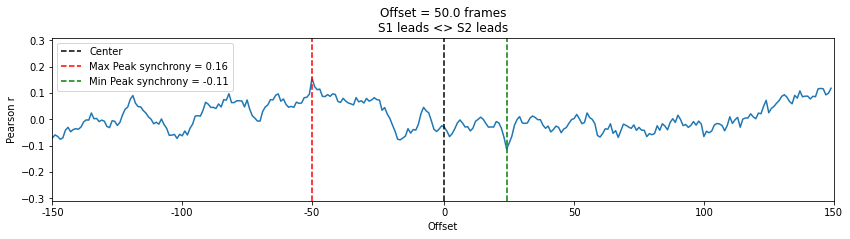

In [95]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    datax = datax.astype('float64')
    datay = datay.astype('float64')
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['return10']
d2 = df['star1']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label=f'Max Peak synchrony = {max(rs).round(2)}')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label= f'Min Peak synchrony = {min(rs).round(2)}')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.31,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()

# Windowed time lagged cross correlation

In [100]:
t*samples_per_split

0.0

In [101]:
samples_per_split

36.55

[Text(0.5, 1.0, 'Rolling Windowed Time Lagged Cross Correlation'),
 (0.0, 15.0),
 Text(0.5, 69.0, 'Offset'),
 Text(69.0, 0.5, 'Epochs')]

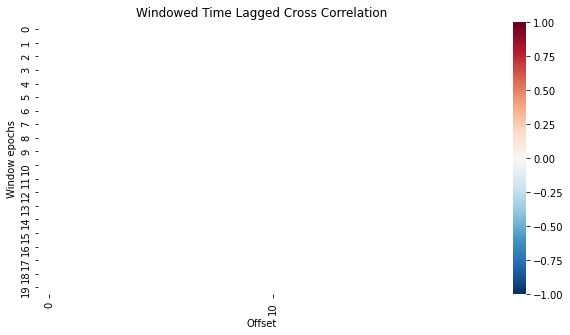

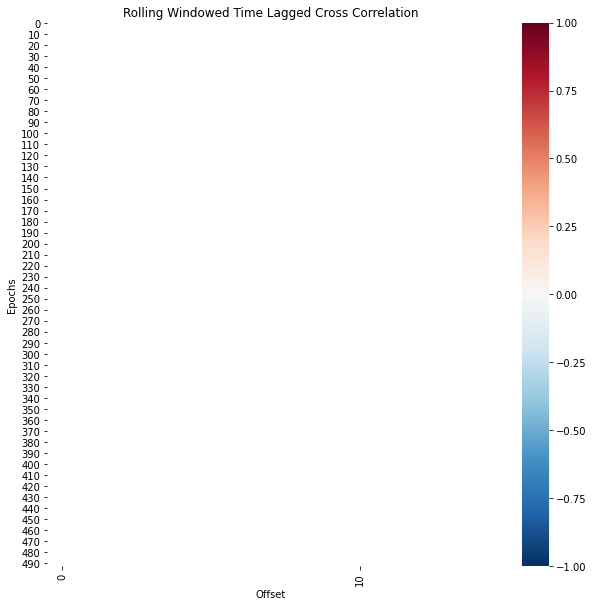

In [112]:
d1_var = "star5"
d2_var = "return1"

n = 200
no_splits = 20
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    start = int((t)*samples_per_split)
    end = int((t+1)*samples_per_split)
    d1 = df[d1_var].iloc[start:end]
    d2 = df[d2_var].iloc[start:end]
    rs = [crosscorr(d1,d2, lag) for lag in range(-n, n + 1)]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,no_splits], xlabel='Offset',ylabel='Window epochs')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

# Rolling window time lagged cross correlation

window_size = 15 #samples
t_start = 0
t_end = t_start + window_size
step_size = 2
rss=[]
while t_end < 1000:
    d1 = df[d1_var].iloc[t_start:t_end]
    d2 = df[d2_var].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-n,n+1)]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,window_size], xlabel='Offset',ylabel='Epochs')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

# Dynamic Time Warping — synchrony of signals varying in lengths

In [133]:
from dtw import dtw

d1 = df['Close'].interpolate().values
d2 = df['Close'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = dtw(d1,d2, dist_method='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

TypeError: cannot unpack non-iterable DTW object

hellO


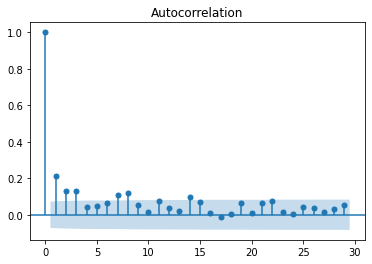

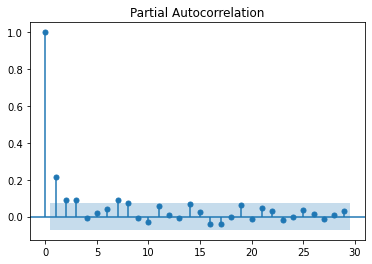

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

hello = df.star1
plot_acf(hello)
plot_pacf(hello)
print("hellO")